<a href="https://colab.research.google.com/github/samik1986/3D_Developing_brain/blob/main/MultiStreamCellSeg_(model_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/samik1986/MultiStreamCellSeg_4_devBrain.git

Cloning into 'MultiStreamCellSeg_4_devBrain'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 109 (delta 18), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (109/109), 570.48 KiB | 4.46 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


gputools
h5py
huggingface-hub
imagecodecs
imageio
importlib-metadata
kiwisolver
llvmlite
Mako
Markdown
MarkupSafe
matplotlib
mkl-fft
mkl-service
monai
networkx
numba
numexpr
numpy
oauthlib
opencv-python
packaging
pandas
Pillow
scikit-image
scipy
stardist
tensorboard
tensorboard-data-server
tensorboard-plugin-wit
tifffile
timm
torch
torchaudio
torchvision
tqdm

In [3]:
# !zip -r /content/MultiStreamCellSeg.zip /content/CellSeg

In [1]:
!pip install -r /content/MultiStreamCellSeg_4_devBrain/requirements.txt

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Upload pretrained model

In [4]:
from MultiStreamCellSeg_4_devBrain.models.flexible_unet_convnext import FlexibleUNet_star

model = FlexibleUNet_star(
    in_channels=3,
    out_channels=33,  # 32 rays + 1 prob channel
    backbone='convnext_small',
    pretrained=False,
    n_rays=32,
    prob_out_channels=1
).to(device)

checkpoint = torch.load('./best_model.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import os
import tifffile as tiff
import torch

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_fnames, mask_fnames, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_fnames = image_fnames
        self.mask_fnames = mask_fnames
        self.transform = transform

    def __len__(self):
        return len(self.image_fnames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_fnames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_fnames[idx])

        # Load image
        img = tiff.imread(img_path).astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # Normalize to [0, 1]

        if img.ndim == 2:  # Grayscale → RGB
            img = np.stack([img] * 3, axis=0)  # [3, H, W]
        elif img.ndim == 3 and img.shape[2] == 3:  # Already RGB
            img = np.transpose(img, (2, 0, 1))  # [H, W, 3] → [3, H, W]

        # Convert to tensor
        img = torch.tensor(img, dtype=torch.float32)

        # Load mask
        mask = tiff.imread(mask_path).astype(np.uint8)
        if mask.ndim == 3:
            mask = mask[..., 0]  # Keep only one channel
        mask = torch.tensor(mask, dtype=torch.long)

        if self.transform:
            img = self.transform(img)

        return img, mask


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Paths
image_dir = "/content/drive/MyDrive/Root/Official/Training/images"
mask_dir = "/content/drive/MyDrive/Root/Official/Training/labels"
# img_names = sorted(os.listdir(image_dir))
# mask_names = sorted(os.listdir(mask_dir))

import re

def natural_key(s):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(r'(\d+)', s)]

img_names = sorted(os.listdir(image_dir), key=natural_key)
mask_names = sorted(os.listdir(mask_dir), key=natural_key)

# Train-test split
train_imgs, val_imgs, train_masks, val_masks = train_test_split(img_names, mask_names, test_size=0.2, random_state=42)

# Dataset and DataLoader
train_dataset = SegmentationDataset(image_dir, mask_dir, train_imgs, train_masks)
val_dataset = SegmentationDataset(image_dir, mask_dir, val_imgs, val_masks)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Model
from MultiStreamCellSeg_4_devBrain.models.flexible_unet_convnext import FlexibleUNet_star

model = FlexibleUNet_star(
    in_channels=3,
    out_channels=33,  # 32 rays + 1 prob channel
    backbone='convnext_small',
    pretrained=False,
    n_rays=32,
    prob_out_channels=1
).to(device)

checkpoint = torch.load('./best_model.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = fcn_resnet50(pretrained=True)
# model.classifier[4] = nn.Conv2d(512, 2, kernel_size=1)  # Binary segmentation (adjust classes if needed)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [8]:
import torch
import torch.nn.functional as F
from scipy.ndimage import distance_transform_edt

def compute_distance_map(mask_tensor):
    """
    Converts instance mask to binary, computes distance transform.
    Args:
        mask_tensor: [B, H, W] with 0=background, 1..n=object ids
    Returns:
        [B, 1, H, W] distance map
    """
    if mask_tensor.dim() == 4:
        mask_tensor = mask_tensor.squeeze(1)

    dist_maps = []
    for i in range(mask_tensor.shape[0]):
        binary = (mask_tensor[i] > 0).cpu().numpy().astype(bool)
        dist = distance_transform_edt(binary)
        dist_maps.append(torch.tensor(dist, dtype=torch.float32))

    return torch.stack(dist_maps).unsqueeze(1).to(mask_tensor.device)

# --- Training loop ---
epochs = 50
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    train_ce_loss, train_dice_loss, train_mae_loss = 0.0, 0.0, 0.0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)  # [B, C, H, W], [B, H, W]

        optimizer.zero_grad()

        pred_rays, pred_prob = model(imgs)  # [B, 32, h, w], [B, 1, h, w]

        # Resize masks
        target_mask = F.interpolate(masks.unsqueeze(1).float(), size=pred_prob.shape[2:], mode='nearest').squeeze(1).long()

        # 1. BCE Loss
        gt_prob_map = (target_mask > 0).float().unsqueeze(1)
        ce_loss = F.binary_cross_entropy_with_logits(pred_prob, gt_prob_map)

        # 2. Distance Losses
        gt_dist_map = compute_distance_map(target_mask)  # [B, 1, h, w]
        pred_dist_map = pred_rays.mean(dim=1, keepdim=True)  # [B, 1, h, w]

        intersection = (gt_dist_map * pred_dist_map).sum()
        dice_loss = 1 - (2 * intersection + 1e-8) / (gt_dist_map.sum() + pred_dist_map.sum() + 1e-8)
        mae_loss = F.l1_loss(pred_dist_map, gt_dist_map)

        # 3. Total loss
        total_loss = ce_loss + dice_loss + 0.3 * mae_loss
        total_loss.backward()
        optimizer.step()

        train_ce_loss += ce_loss.item()
        train_dice_loss += dice_loss.item()
        train_mae_loss += mae_loss.item()

    # --- Validation ---
    model.eval()
    val_ce_loss, val_dice_loss, val_mae_loss = 0.0, 0.0, 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)

            pred_rays, pred_prob = model(imgs)

            target_mask = F.interpolate(masks.unsqueeze(1).float(), size=pred_prob.shape[2:], mode='nearest').squeeze(1).long()
            gt_prob_map = (target_mask > 0).float().unsqueeze(1)
            ce_loss = F.binary_cross_entropy_with_logits(pred_prob, gt_prob_map)

            gt_dist_map = compute_distance_map(target_mask)
            pred_dist_map = pred_rays.mean(dim=1, keepdim=True)

            intersection = (gt_dist_map * pred_dist_map).sum()
            dice_loss = 1 - (2 * intersection + 1e-8) / (gt_dist_map.sum() + pred_dist_map.sum() + 1e-8)
            mae_loss = F.l1_loss(pred_dist_map, gt_dist_map)

            val_ce_loss += ce_loss.item()
            val_dice_loss += dice_loss.item()
            val_mae_loss += mae_loss.item()

            val_total_loss = val_ce_loss + val_dice_loss + 0.3 * val_mae_loss

            if val_total_loss < best_val_loss:
                best_val_loss = val_total_loss
                torch.save(model.state_dict(), "MultiStream_model_best.pth")
                print(f"Best model saved at epoch {epoch+1} with val loss {best_val_loss:.4f}")
                #Best model saved at epoch 17 with val loss 1.6584

    # --- Print Epoch Results ---
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train  | CE: {train_ce_loss:.4f} | Dice: {train_dice_loss:.4f} | MAE: {train_mae_loss:.4f}")
    print(f"Val    | CE: {val_ce_loss:.4f} | Dice: {val_dice_loss:.4f} | MAE: {val_mae_loss:.4f}")
    print("-" * 60)

torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([3, 32, 248, 248])
torch.Size

torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([1, 32, 248, 248])
9

Validation Loss: 19.0560


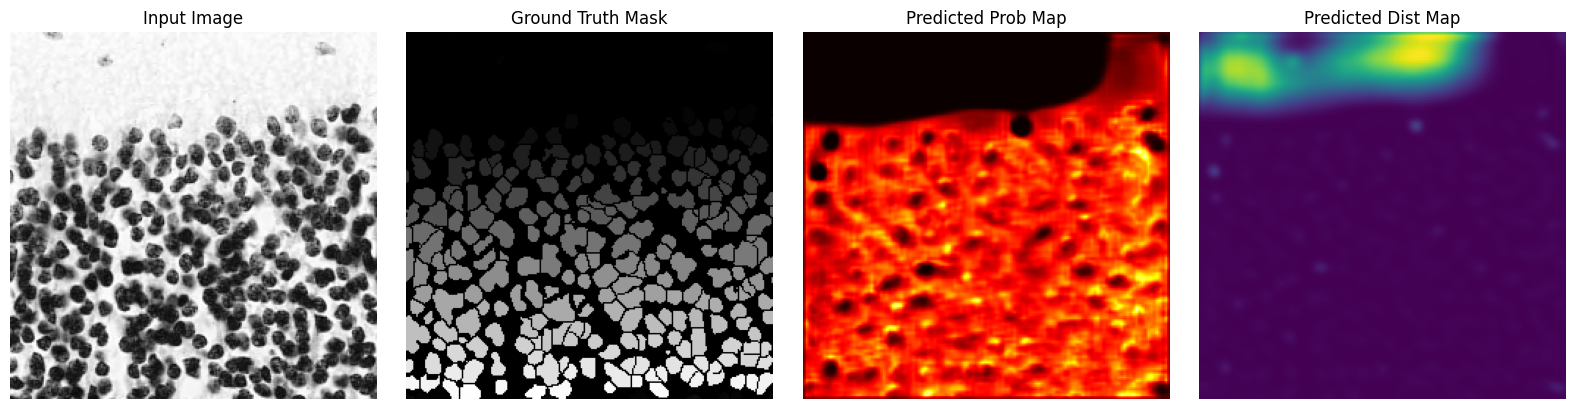

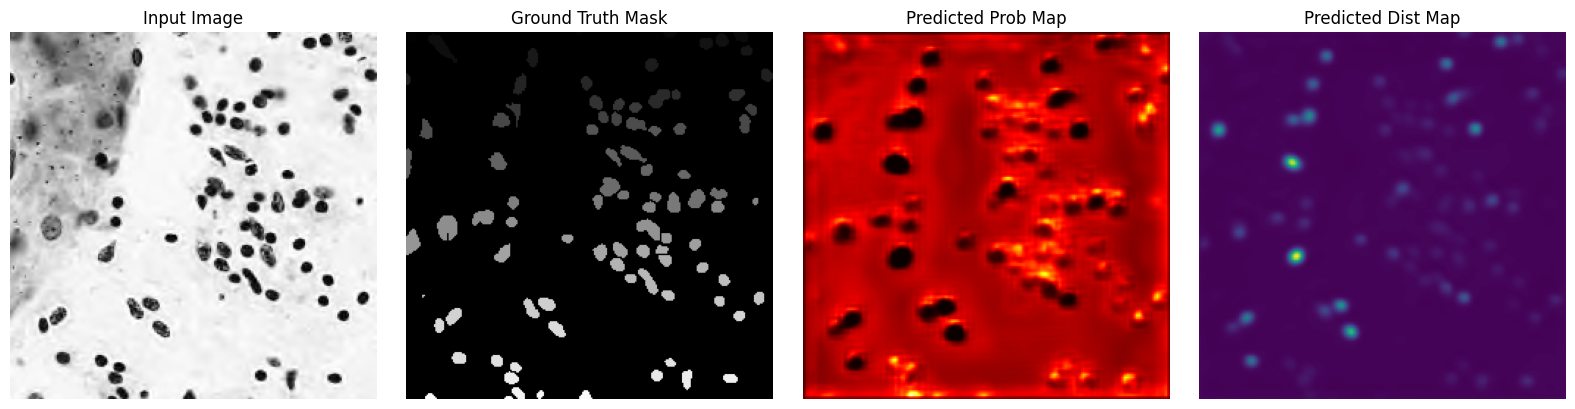

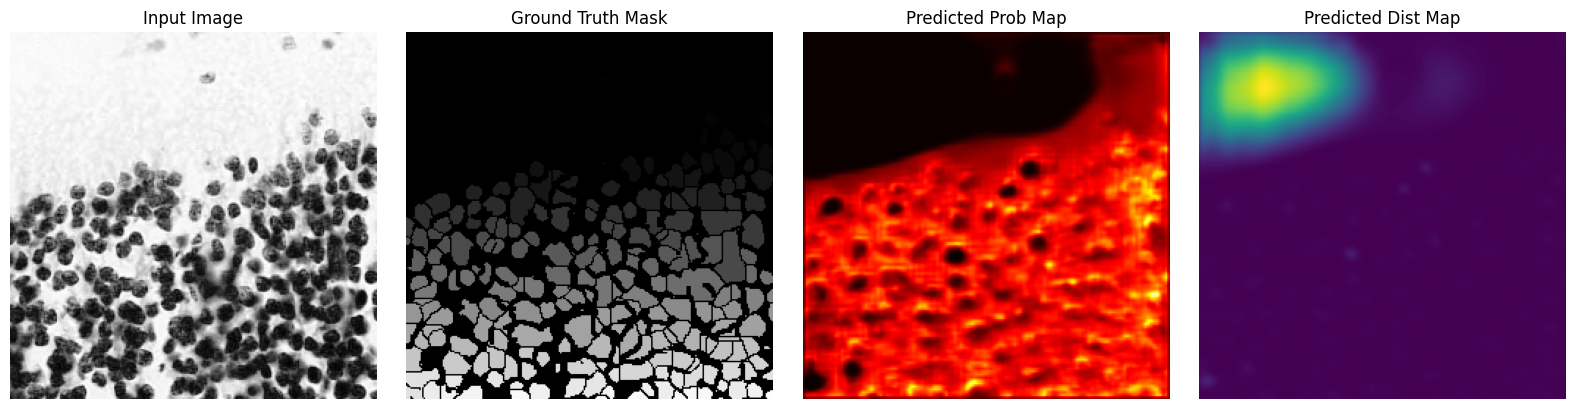

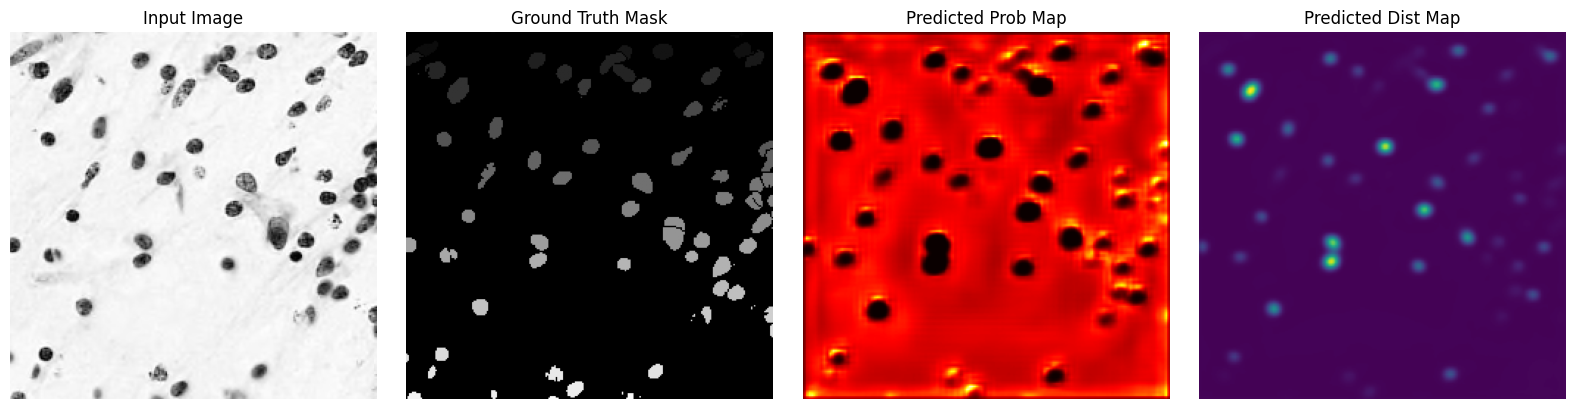

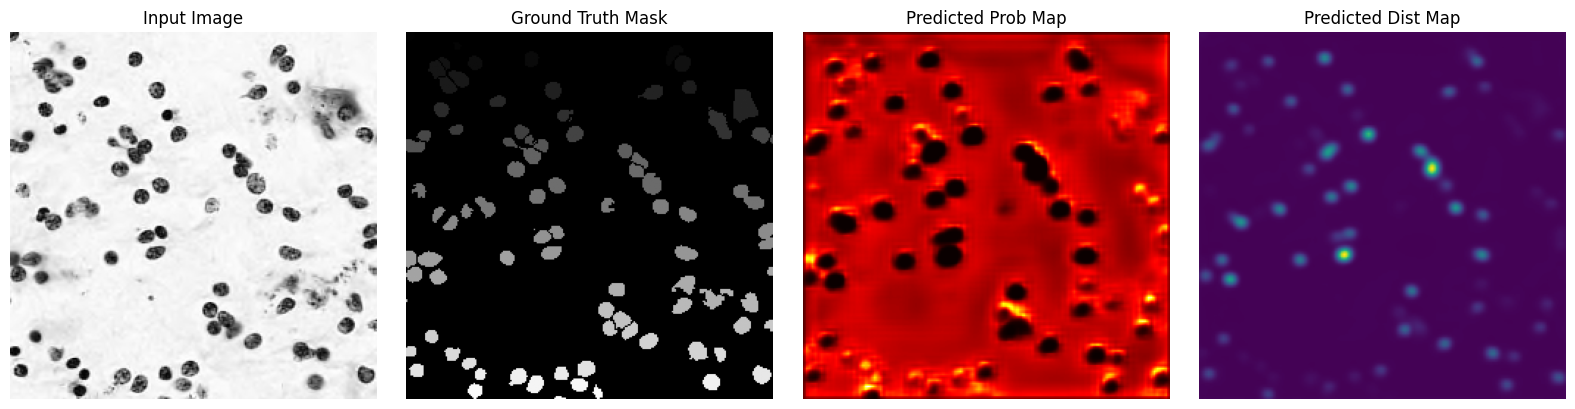

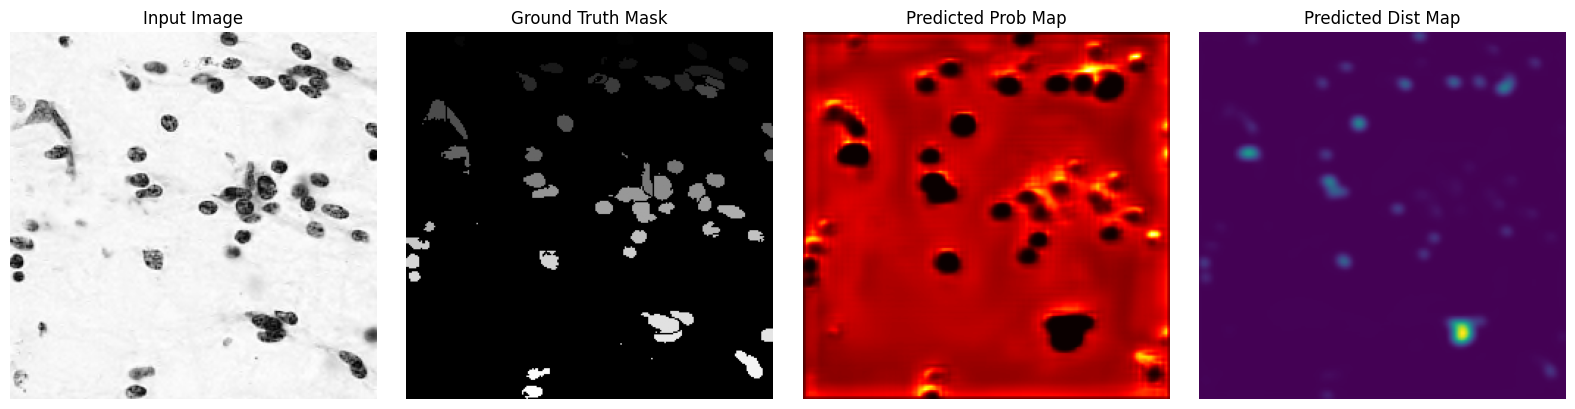

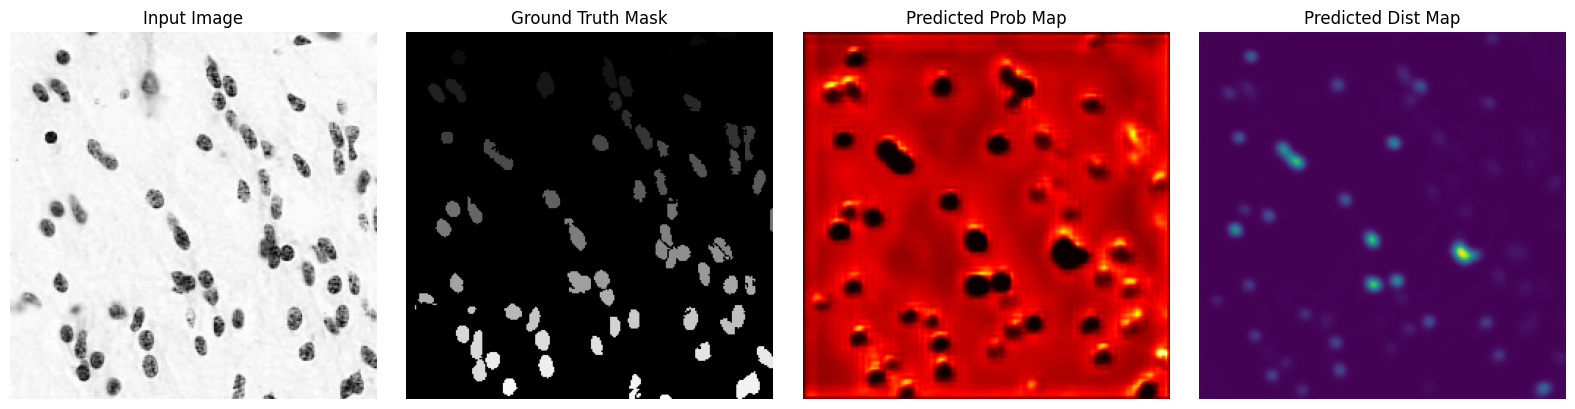

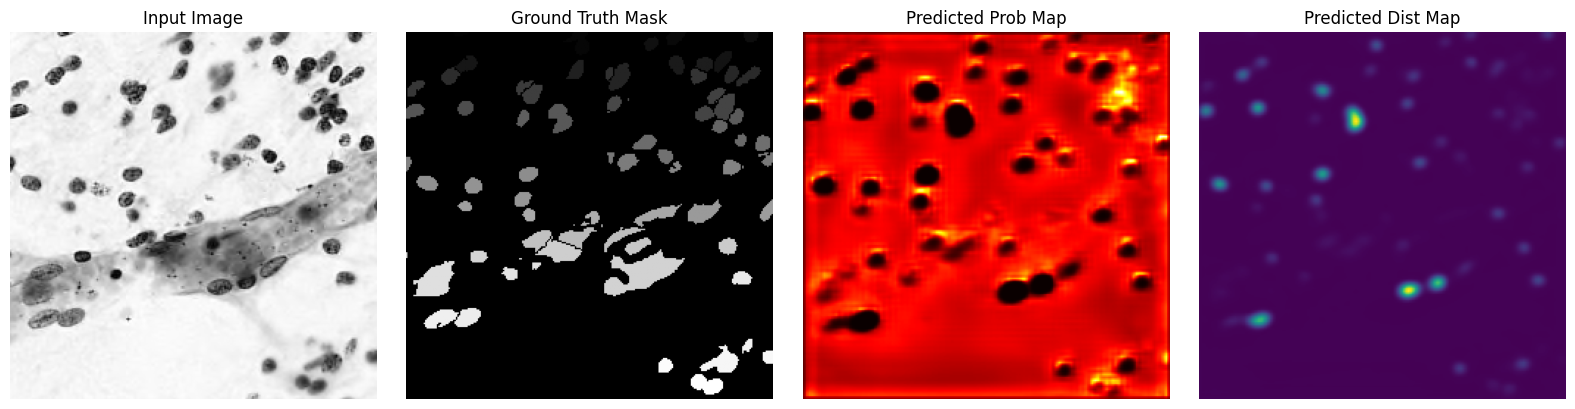

In [9]:
import matplotlib.pyplot as plt

model.eval()
val_total_loss = 0
all_preds = []
all_probs = []
all_dists = []
all_gts = []

all_imgs = []
all_masks = []

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        pred_rays, pred_prob = model(imgs)

        target_mask = F.interpolate(masks.unsqueeze(1).float(), size=pred_prob.shape[2:], mode='nearest').squeeze(1).long()
        gt_prob_map = (target_mask > 0).float().unsqueeze(1)
        ce_loss = F.binary_cross_entropy_with_logits(pred_prob, gt_prob_map)

        gt_dist_map = compute_distance_map(target_mask)
        pred_dist_map = pred_rays.mean(dim=1, keepdim=True)

        intersection = (gt_dist_map * pred_dist_map).sum()
        dice_loss = 1 - (2 * intersection + 1e-8) / (gt_dist_map.sum() + pred_dist_map.sum() + 1e-8)

        mae_loss = F.l1_loss(pred_dist_map, gt_dist_map)
        total_loss = ce_loss + dice_loss + 0.3 * mae_loss

        val_total_loss += total_loss.item()

        all_preds.append(pred_prob.sigmoid().cpu())
        all_probs.append(gt_prob_map.cpu())
        all_dists.append(pred_dist_map.cpu())
        all_gts.append(gt_dist_map.cpu())
        all_imgs.append(imgs.cpu())
        all_masks.append(masks.cpu())

print(len(all_masks))
# Average validation loss
avg_val_loss = val_total_loss / len(val_loader)
print(f"\nValidation Loss: {avg_val_loss:.4f}")

n_samples = min(4, all_imgs[-1].shape[0])  # use actual image count in last batch

N = 8  # total number of images you want to show
shown = 0

for batch_imgs, batch_masks, batch_preds, batch_dists in zip(all_imgs, all_masks, all_preds, all_dists):
    B = batch_imgs.shape[0]  # batch size
    for i in range(B):
        if shown >= N:
            break

        fig, axs = plt.subplots(1, 4, figsize=(16, 4))

        axs[0].imshow(batch_imgs[i].permute(1, 2, 0).cpu(), cmap='gray')
        axs[0].set_title("Input Image")

        axs[1].imshow(batch_masks[i].cpu(), cmap='gray')
        axs[1].set_title("Ground Truth Mask")

        axs[2].imshow(batch_preds[i][0].cpu(), cmap='hot')
        axs[2].set_title("Predicted Prob Map")

        axs[3].imshow(batch_dists[i][0].cpu(), cmap='viridis')
        axs[3].set_title("Predicted Dist Map")

        for ax in axs:
            ax.axis('off')

        plt.tight_layout()
        plt.show()

        shown += 1
    if shown >= N:
        break


post processing

In [10]:
import numpy as np
import torch
import cv2
from skimage.feature import peak_local_max
from skimage.segmentation import watershed  # <-- updated import
from scipy import ndimage as ndi

In [11]:
from skimage.measure import label
from skimage.morphology import remove_small_objects
from skimage.segmentation import watershed
from scipy.ndimage import label as ndi_label
from skimage.feature import peak_local_max
import numpy as np

def postprocess_nms(prob_map, dist_map, prob_thresh=0.015, min_distance=1):
    # Inputs are numpy arrays already
    mask_thresh = prob_map < prob_thresh

    # 1. Local maxima for seeds
    coordinates = peak_local_max(dist_map, labels=mask_thresh, min_distance=min_distance)
    seed_mask = np.zeros_like(dist_map, dtype=np.int32)
    for idx, (y, x) in enumerate(coordinates, 1):
        seed_mask[y, x] = idx

    # 2. Watershed segmentation
    markers, _ = ndi_label(seed_mask)
    instance_mask = watershed(-dist_map, markers, mask=mask_thresh)

    # 3. Optional: remove tiny objects
    instance_mask = remove_small_objects(instance_mask, min_size=1)

    return instance_mask

torch.Size([4, 32, 248, 248])


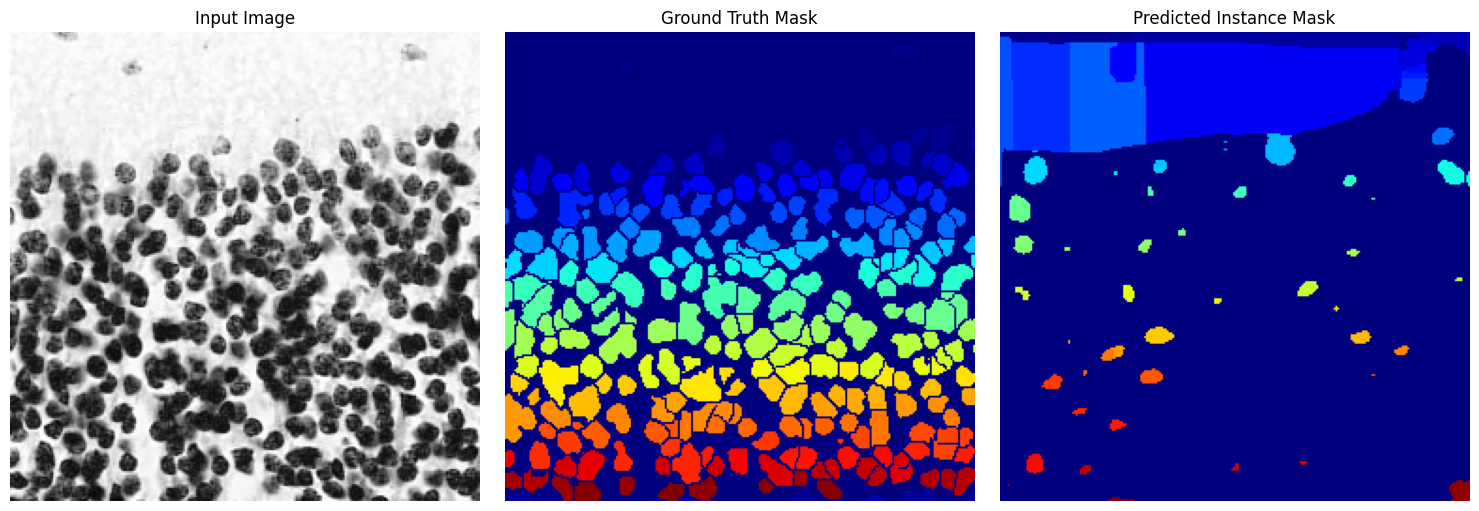

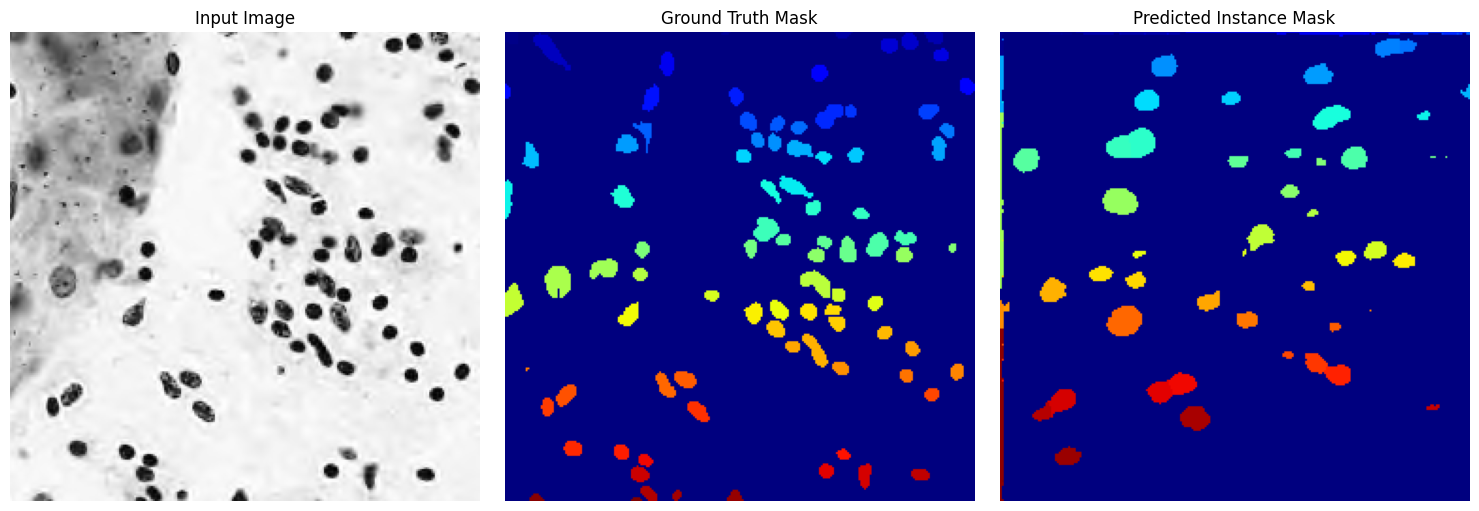

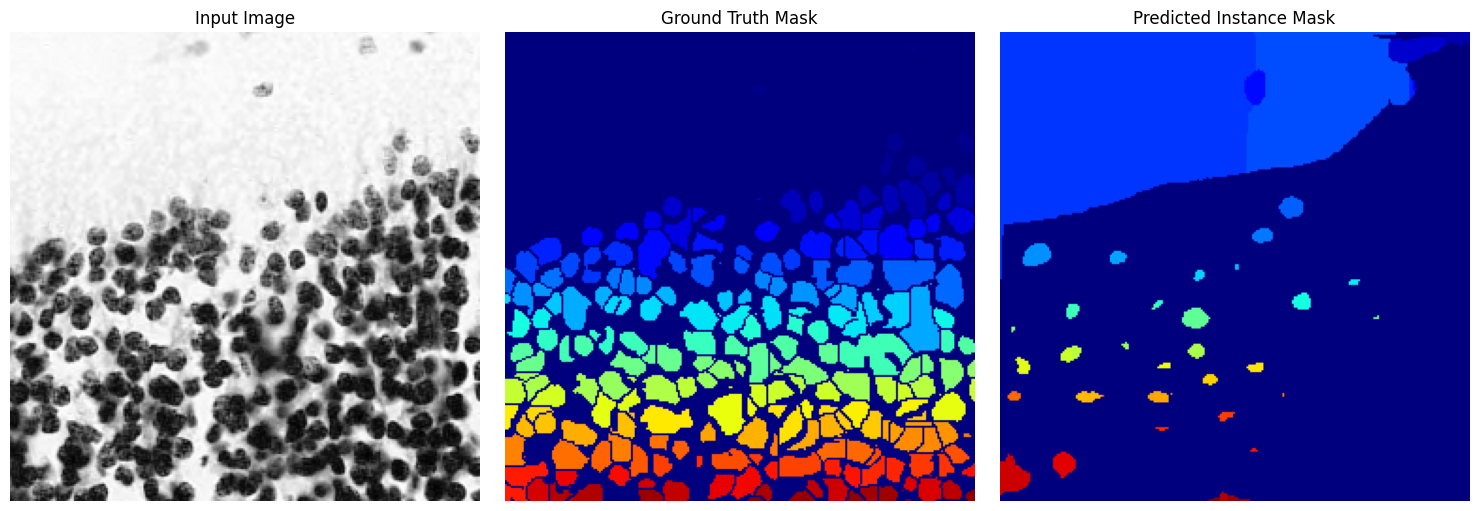

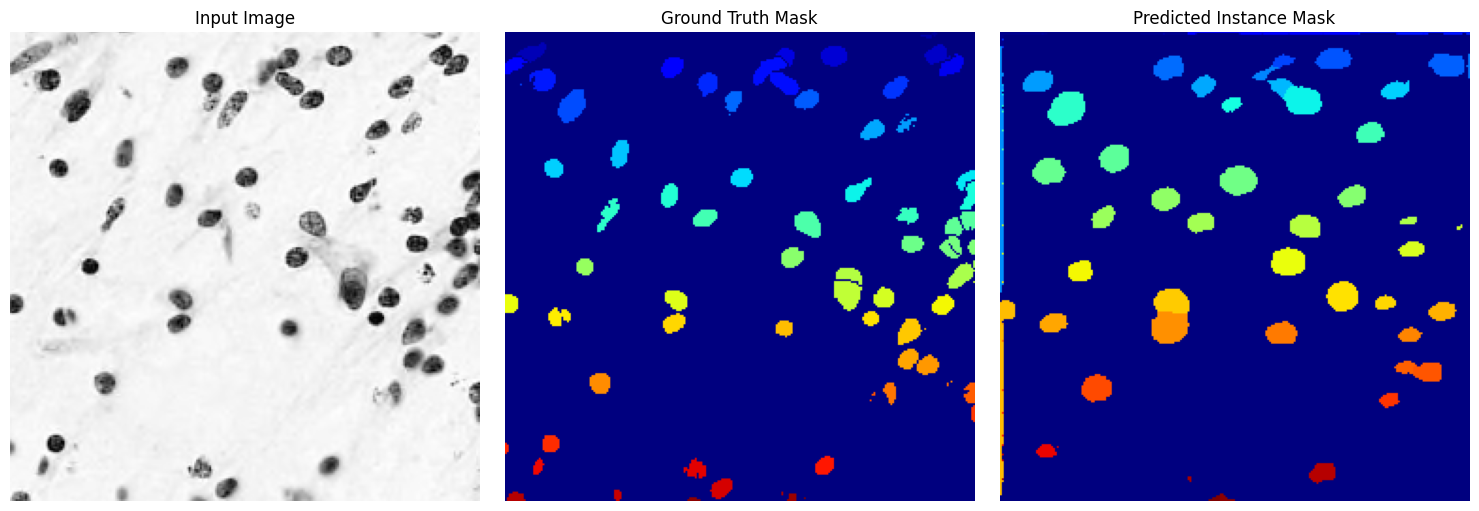

torch.Size([4, 32, 248, 248])


In [12]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_predictions(model, val_loader, postprocess_nms, device, n_samples=4):
    model.eval()
    count = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)

            # Model prediction
            pred_rays, pred_prob = model(imgs)
            pred_dist_map = pred_rays.mean(dim=1, keepdim=True)  # Shape: [B, 1, H, W]

            for i in range(imgs.size(0)):
                if count >= n_samples:
                    return

                # Extract current image, ground truth, predicted prob & dist map
                img = imgs[i].cpu().numpy().transpose(1, 2, 0)
                mask = masks[i].cpu().numpy()
                prob_map = pred_prob[i, 0].cpu().numpy()
                dist_map = pred_dist_map[i, 0].cpu().numpy()

                # Postprocess to get instance mask
                instance_mask = postprocess_nms(prob_map, dist_map)

                # Plot
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                axs[0].imshow(img.astype(np.float32))
                axs[0].set_title("Input Image")
                axs[0].axis('off')

                axs[1].imshow(mask, cmap='jet')
                axs[1].set_title("Ground Truth Mask")
                axs[1].axis('off')

                axs[2].imshow(instance_mask, cmap='jet')
                axs[2].set_title("Predicted Instance Mask")
                axs[2].axis('off')

                plt.tight_layout()
                plt.show()

                count += 1

visualize_predictions(model, val_loader, postprocess_nms, device, n_samples=4)

In [13]:
import numpy as np
from scipy.ndimage import center_of_mass
from scipy.spatial.distance import cdist

def compute_centroids(instance_mask):
    labels = np.unique(instance_mask)
    labels = labels[labels != 0]  # Exclude background
    centroids = []
    for label in labels:
        mask = (instance_mask == label)
        centroid = center_of_mass(mask)
        centroids.append(centroid)
    return np.array(centroids)

def match_centroids(gt_mask, pred_mask, radius=5):
    gt_centroids = compute_centroids(gt_mask)
    pred_centroids = compute_centroids(pred_mask)

    if len(gt_centroids) == 0 and len(pred_centroids) == 0:
        return 0, 0, 0

    if len(gt_centroids) == 0:
        return 0, len(pred_centroids), 0

    if len(pred_centroids) == 0:
        return 0, 0, len(gt_centroids)

    dist_matrix = cdist(pred_centroids, gt_centroids)

    matched_gt = set()
    matched_pred = set()

    # Flatten the distance matrix with (i, j, distance) tuples
    pairs = [
        (i, j, dist_matrix[i, j])
        for i in range(dist_matrix.shape[0])
        for j in range(dist_matrix.shape[1])
        if dist_matrix[i, j] <= radius
    ]

    # Sort by distance (greedy: match closest pairs first)
    pairs.sort(key=lambda x: x[2])

    for i, j, d in pairs:
        if i not in matched_pred and j not in matched_gt:
            matched_pred.add(i)
            matched_gt.add(j)

    TP = len(matched_pred)
    FP = len(pred_centroids) - TP
    FN = len(gt_centroids) - TP

    return TP, FP, FN

def compute_metrics(TP, FP, FN):
    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    accuracy = TP / (TP + FP + FN + 1e-8)
    return {
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Accuracy': accuracy
    }

In [15]:
total_TP = 0
total_FP = 0
total_FN = 0
count = 0

model.eval()

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        pred_rays, pred_prob = model(imgs)
        pred_dist_map = pred_rays.mean(dim=1, keepdim=True)

        for i in range(imgs.size(0)):
            if count >= n_samples:
                break  # to avoid return inside loop

            img = imgs[i].cpu().numpy().transpose(1, 2, 0)
            mask = masks[i].cpu().numpy()
            prob_map = pred_prob[i, 0].cpu().numpy()
            dist_map = pred_dist_map[i, 0].cpu().numpy()

            instance_mask = postprocess_nms(prob_map, dist_map)

            # Compute TP, FP, FN for current image
            TP, FP, FN = match_centroids(mask, instance_mask, radius=5)
            total_TP += TP
            total_FP += FP
            total_FN += FN

            count += 1
metrics = compute_metrics(total_TP, total_FP, total_FN)

print("\n=== Average Detection Metrics ===")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([4, 32, 248, 248])
torch.Size([1, 32, 248, 248])

=== Average Detection Metrics ===
TP: 38.0000
FP: 21.0000
FN: 217.0000
Precision: 0.6441
Recall: 0.1490
F1: 0.2420
Accuracy: 0.1377
